=== Training the Classic Transformer ===
Epoch 1/10, Loss: 0.4044
Epoch 2/10, Loss: 0.2836
Epoch 3/10, Loss: 0.2630
Epoch 4/10, Loss: 0.2523
Epoch 5/10, Loss: 0.2436
Epoch 6/10, Loss: 0.2361
Epoch 7/10, Loss: 0.2293
Epoch 8/10, Loss: 0.2242
Epoch 9/10, Loss: 0.2187
Epoch 10/10, Loss: 0.2150
Test Loss: 0.4295
Classic Transformer model saved as 'model_classic.pth'.
=== Training the Transformer with FAN ===
Epoch 1/10, Loss: 0.4063
Epoch 2/10, Loss: 0.2845
Epoch 3/10, Loss: 0.2621
Epoch 4/10, Loss: 0.2497
Epoch 5/10, Loss: 0.2390
Epoch 6/10, Loss: 0.2313
Epoch 7/10, Loss: 0.2239
Epoch 8/10, Loss: 0.2168
Epoch 9/10, Loss: 0.2110
Epoch 10/10, Loss: 0.2055
Test Loss: 0.4708
Transformer with FAN model saved as 'model_fan.pth'.


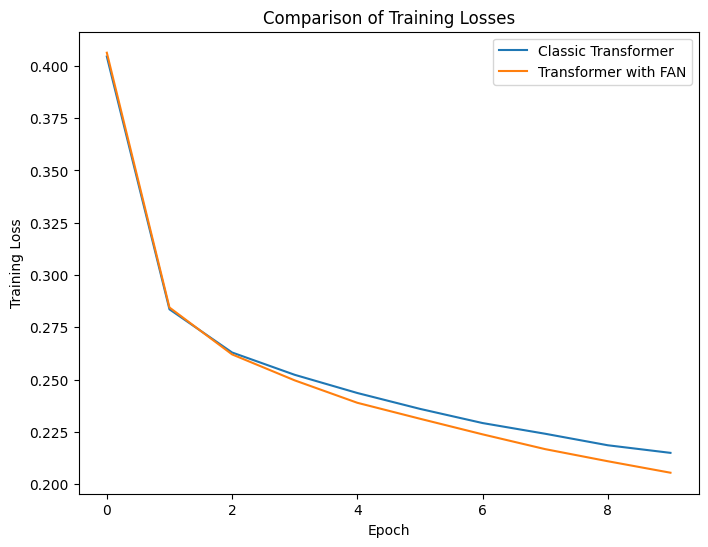

In [2]:
# Transformer_FAN_vs_Classic.ipynb

# In[1]: Import libraries and modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from data_loader import load_etth1
from models import TransformerForecast
from tqdm import tqdm


# In[2]: Define training and evaluation functions

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
        
        for x, y in progress_bar:
            x = x.to(device)  # x: (batch, seq_len, input_size)
            y = y.to(device)  # y: (batch, pred_len, input_size)
            optimizer.zero_grad()
            outputs = model(x)  # outputs: (batch, pred_len, input_size)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            
            # Update tqdm progress bar with current loss
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
        losses.append(epoch_loss)
    
    return losses


def evaluate_model(model, test_loader, criterion, device='cpu'):
    model.to(device)
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(test_loader.dataset)
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss

# In[3]: Parameters and data loading
seq_len = 96           # Length of the input sequence
pred_len = 24          # Length of the prediction window
batch_size = 32
num_epochs = 10
learning_rate = 0.001
d_model = 64
nhead = 4
num_layers = 2
d_ff = 128
input_size = 7         # Multivariate: for example, 7 variables (HUFL, HULL, MUFL, MULL, LUFL, LULL, OT)

# Ensure that the 'data/ETTh1.csv' file is available and prepared for multivariate input
train_dataset, test_dataset = load_etth1('data/ETTh1.csv', seq_len, pred_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

# In[4]: Training the Classic Transformer
print("=== Training the Classic Transformer ===")
model_classic = TransformerForecast(input_size, d_model, nhead, num_layers, d_ff, pred_len, use_fan=False)
optimizer_classic = optim.Adam(model_classic.parameters(), lr=learning_rate)
losses_classic = train_model(model_classic, train_loader, criterion, optimizer_classic, num_epochs, device)
test_loss_classic = evaluate_model(model_classic, test_loader, criterion, device)

# Save the Classic Transformer model
torch.save(model_classic.state_dict(), 'results/model_classic.pth')
print("Classic Transformer model saved as 'model_classic.pth'.")


# In[5]: Training the Transformer with FAN
print("=== Training the Transformer with FAN ===")
model_fan = TransformerForecast(input_size, d_model, nhead, num_layers, d_ff, pred_len, use_fan=True, fan_p_ratio=0.25)
optimizer_fan = optim.Adam(model_fan.parameters(), lr=learning_rate)
losses_fan = train_model(model_fan, train_loader, criterion, optimizer_fan, num_epochs, device)
test_loss_fan = evaluate_model(model_fan, test_loader, criterion, device)

# Save the Transformer with FAN model
torch.save(model_fan.state_dict(), 'results/model_fan.pth')
print("Transformer with FAN model saved as 'model_fan.pth'.")

# In[6]: Compare training loss curves
plt.figure(figsize=(8,6))
plt.plot(losses_classic, label='Classic Transformer')
plt.plot(losses_fan, label='Transformer with FAN')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Comparison of Training Losses")
plt.legend()
plt.show()



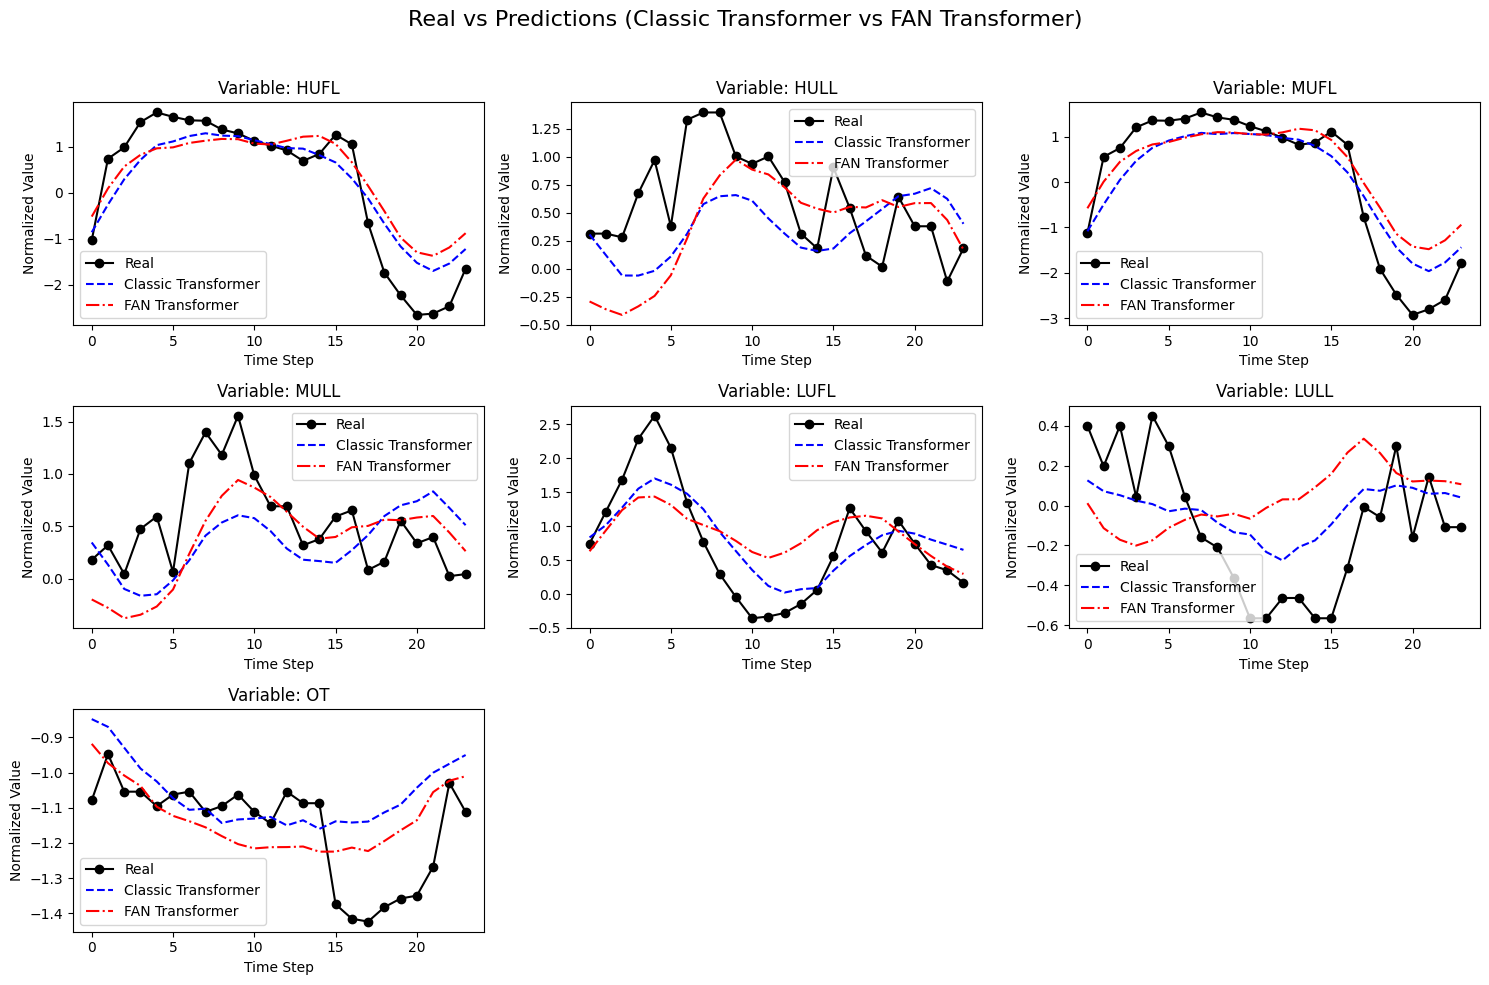

In [4]:
# Load Classic Transformer
model_classic = TransformerForecast(input_size, d_model=64, nhead=4, num_layers=2, d_ff=128, pred_len=pred_len, use_fan=False)
model_classic.load_state_dict(torch.load('results/model_classic.pth', map_location=device))  # Replace with your classic model file
model_classic.to(device)
model_classic.eval()

# Load FAN Transformer
model_fan = TransformerForecast(input_size, d_model=64, nhead=4, num_layers=2, d_ff=128, pred_len=pred_len, use_fan=True, fan_p_ratio=0.25)
model_fan.load_state_dict(torch.load('results/model_fan.pth', map_location=device))  # Replace with your FAN model file
model_fan.to(device)
model_fan.eval()

# Variable names
variables = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

# Get predictions for the first batch in the test set
with torch.no_grad():
    for x, y_true in test_loader:
        x = x.to(device)
        y_true = y_true.to(device)

        # Predictions from both models
        y_pred_classic = model_classic(x)
        y_pred_fan = model_fan(x)
        break  # We only need the first batch for plotting

# Convert predictions and true values to numpy arrays for plotting
y_true = y_true.cpu().numpy()[0]          # Shape: (pred_len, input_size)
y_pred_classic = y_pred_classic.cpu().numpy()[0]  # Shape: (pred_len, input_size)
y_pred_fan = y_pred_fan.cpu().numpy()[0]          # Shape: (pred_len, input_size)

# Plotting real vs predictions from both models for each variable
fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # 3x3 grid for 7 variables (2 empty)
fig.suptitle('Real vs Predictions (Classic Transformer vs FAN Transformer)', fontsize=16)

for i in range(7):
    row = i // 3
    col = i % 3
    axs[row, col].plot(y_true[:, i], label='Real', marker='o', color='black')
    axs[row, col].plot(y_pred_classic[:, i], label='Classic Transformer', linestyle='--', color='blue')
    axs[row, col].plot(y_pred_fan[:, i], label='FAN Transformer', linestyle='-.', color='red')
    axs[row, col].set_title(f'Variable: {variables[i]}')
    axs[row, col].set_xlabel('Time Step')
    axs[row, col].set_ylabel('Normalized Value')
    axs[row, col].legend()

# Hide the empty subplots
for i in range(7, 9):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.show()
